In [1]:
import folktables
from folktables import adult_filter,public_coverage_filter
import numpy as np

ACSIncome_categories = {
    "COW": {
        1.0: (
            "Employee of a private for-profit company or"
            "business, or of an individual, for wages,"
            "salary, or commissions"
        ),
        2.0: (
            "Employee of a private not-for-profit, tax-exempt,"
            "or charitable organization"
        ),
        3.0: "Local government employee (city, county, etc.)",
        4.0: "State government employee",
        5.0: "Federal government employee",
        6.0: (
            "Self-employed in own not incorporated business,"
            "professional practice, or farm"
        ),
        7.0: (
            "Self-employed in own incorporated business,"
            "professional practice or farm"
        ),
        8.0: "Working without pay in family business or farm",
        9.0: "Unemployed and last worked 5 years ago or earlier or never worked",
    },
    "SCHL": {
        1.0: "No schooling completed",
        2.0: "Nursery school, preschool",
        3.0: "Kindergarten",
        4.0: "Grade 1",
        5.0: "Grade 2",
        6.0: "Grade 3",
        7.0: "Grade 4",
        8.0: "Grade 5",
        9.0: "Grade 6",
        10.0: "Grade 7",
        11.0: "Grade 8",
        12.0: "Grade 9",
        13.0: "Grade 10",
        14.0: "Grade 11",
        15.0: "12th grade - no diploma",
        16.0: "Regular high school diploma",
        17.0: "GED or alternative credential",
        18.0: "Some college, but less than 1 year",
        19.0: "1 or more years of college credit, no degree",
        20.0: "Associate's degree",
        21.0: "Bachelor's degree",
        22.0: "Master's degree",
        23.0: "Professional degree beyond a bachelor's degree",
        24.0: "Doctorate degree",
    },
    "MAR": {
        1.0: "Married",
        2.0: "Widowed",
        3.0: "Divorced",
        4.0: "Separated",
        5.0: "Never married or under 15 years old",
    },
    "SEX": {1.0: "Male", 2.0: "Female"},
    "RAC1P": {
        1.0: "White alone",
        2.0: "Black or African American alone",
        3.0: "American Indian alone",
        4.0: "Alaska Native alone",
        5.0: (
            "American Indian and Alaska Native tribes specified;"
            "or American Indian or Alaska Native,"
            "not specified and no other"
        ),
        6.0: "Asian alone",
        7.0: "Native Hawaiian and Other Pacific Islander alone",
        8.0: "Some Other Race alone",
        9.0: "Two or More Races",
    },
}

In [2]:
import logging
import os
import pickle
import time

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from folktables import (ACSDataSource, ACSEmployment, ACSIncome,
                        ACSPublicCoverage, generate_categories)

STATE_LIST = [
    "AL","AK", "AZ", "AR", "CA", "CO",  "CT",  "DE",  "FL",  "GA",  "HI",  "ID",
    "IL",  "IN",  "IA",  "KS",  "KY",  "LA",  "ME",  "MD",  "MA",  "MI",
    "MN",  "MS",  "MO",  "MT",  "NE",  "NV",  "NH",  "NJ",  "NM",  "NY", "NC",
    "ND",  "OH",  "OK",  "OR","PA",  "RI",  "SC",  "SD",  "TN",  "TX",  "UT",
    "VT",  "VA",  "WA",  "WV",  "WI",  "WY",  "PR",
]


state_data = dict()
for state in STATE_LIST:
    data_source = ACSDataSource(
            survey_year="2018",
            horizon="1-Year",
            survey="person" )
    acs_data = data_source.get_data(states=[state], download=True)
    x, y, s = ACSIncome.df_to_pandas(
                acs_data, categories=ACSIncome_categories, dummies=True)
    x, y, s = x.to_numpy()*1, y.to_numpy().flatten()*1, s.to_numpy().flatten()
    
    sc = StandardScaler()
    x = sc.fit_transform(x)
    
    X_train = x[0:1000]
    X_test = x[1000:3000]
    y_train = y[0:1000]
    y_test = y[1000:3000]
    race_train = s[0:1000]
    race_test = s[1000:3000]
    
    state_data[state] = ([X_train, X_test, y_train, y_test,
                         race_train, race_test] )

In [4]:
#acs_data.columns

In [47]:
from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import demographic_parity_difference
from model import MCLogisticRegression 

#Federated Learning.
average_local_testing_acc = []
average_global_testing_acc = []


iteration = 200
fedavg_weight = None
fedavg_intercept = None

fedavg_local_eod_race = []
fedavg_local_eod_sex = []
fedavg_local_dpr_race = []
fedavg_local_dpr_sex = []

fedavg_global_eod_race = []
fedavg_global_eod_sex = []
fedavg_global_dpr_race = []
fedavg_global_dpr_sex = []

for i in range(iteration):
    weights = []
    intercepts = []
    local_testing_acc = []
    global_testing_acc = []
    
    local_eod_race = []
    local_eod_sex = []
    local_dpr_race = []
    local_dpr_sex = []
    
    global_eod_race = []
    global_eod_sex = []
    global_dpr_race = []
    global_dpr_sex = []
    
    for st in STATE_LIST:
        #get only data for the st(state.)
        # X = X_local[st]["X"]
        # sex = X_local[st]["sex"]
        # race = X_local[st]["race"]
        # y = y_local[st]
        
        # X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
        #                         train_test_split(X, y, sex, race, test_size=0.3)
        
        ([X_train, X_test, y_train, y_test,
        race_train, race_test] ) = state_data[st]  
        model = MCLogisticRegression(X_train, y_train, X_test, y_test, 
                                     0.2, 1, 2, fedavg_weight, 
                                     fedavg_intercept)
        #Training 
        model.train()
        
        #pred for local data
        y_pred = model.predict(X_test)
        local_acc = np.mean(y_pred == y_test)
        weights.append(model.w.tolist())
        intercepts.append(model.b.tolist())
        
        if((i+1) % 10 == 0):
         #local data
            local_testing_acc.append(local_acc)
        
            #Calculate local OE and DP
            local_eod_race_state = equalized_odds_difference(y_test, y_pred, sensitive_features=race_test)
            #local_eod_sex_state = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_test)
            local_dpr_race_state = demographic_parity_difference(y_test,y_pred, sensitive_features=race_test)
            #local_dpr_sex_state = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_test)
            
            #Store local OE and DP for each state.
            local_eod_race.append(local_eod_race_state)
            #local_eod_sex.append(local_eod_sex_state)
            local_dpr_race.append(local_dpr_race_state)
            #local_dpr_sex.append(local_dpr_sex_state)
        
        #global data
            # X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
            #                         train_test_split(X_global, y_global, sex_global, race_global, test_size=0.3)
            # y_pred = model.predict(X_test)
            # global_acc = np.mean(y_pred == y_test)
            # global_testing_acc.append(global_acc)
            
            # #Calculate global OE and DP
            # global_eod_race_state = equalized_odds_difference(y_test, y_pred, sensitive_features=race_test)
            # global_eod_sex_state = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_test)
            # global_dpr_race_state = demographic_parity_difference(y_test,y_pred, sensitive_features=race_test)
            # global_dpr_sex_state = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_test)
            
            # #Store global OE and DP for each state.
            # global_eod_race.append(global_eod_race_state)
            # global_eod_sex.append(global_eod_sex_state)
            # global_dpr_race.append(global_dpr_race_state)
            # global_dpr_sex.append(global_dpr_sex_state) 
        
    if((i+1) %10 ==0):
        print("iteration", (i+1))
    
    #mean of weights and update the fedavg weights and intercept
    fedavg_weight = np.array(weights).mean(axis=0)
    fedavg_intercept = np.array(intercepts).mean()
    
    if((i+1) % 10 == 0):
    #local
        average_local_testing_acc.append(np.mean(local_testing_acc))
        fedavg_local_eod_race.append(np.mean(local_eod_race))
        #fedavg_local_eod_sex.append(np.mean(local_eod_sex))
        fedavg_local_dpr_race.append(np.mean(local_dpr_race))
       # fedavg_local_dpr_sex.append(np.mean(local_dpr_sex))
    
    #global
        # average_global_testing_acc.append(np.mean(global_testing_acc))
        # fedavg_global_eod_race.append(np.mean(global_eod_race))
        # fedavg_global_eod_sex.append(np.mean(global_eod_sex))
        # fedavg_global_dpr_race.append(np.mean(global_dpr_race))
        # fedavg_global_dpr_sex.append(np.mean(global_dpr_sex))

iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200


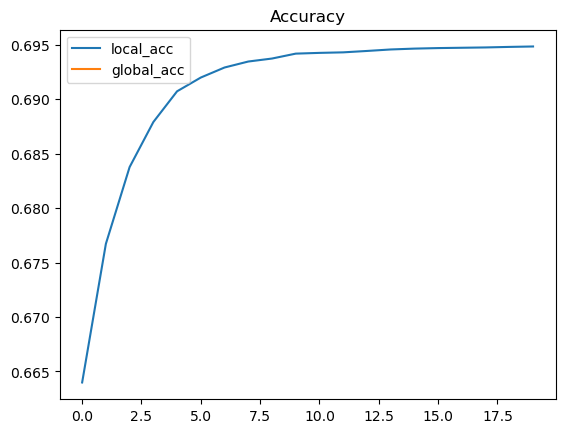

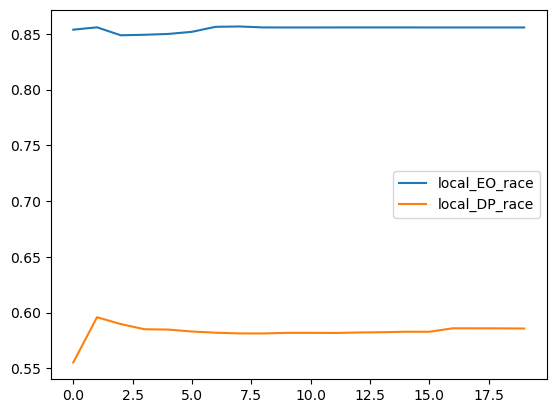

FedAvg local dataset
local_Accuracy 0.6948431372549022
local_EO_race 0.8557827159604762
local_DP_race 0.5856191185521277


In [48]:
import matplotlib.pyplot as plt

plt.plot(average_local_testing_acc, label='local_acc')
plt.plot(average_global_testing_acc, label='global_acc')

plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(fedavg_local_eod_race, label='local_EO_race')
#plt.plot(fedavg_local_eod_sex, label='local_EO_sex')
plt.plot(fedavg_local_dpr_race,label='local_DP_race')
#plt.plot(fedavg_local_dpr_sex,label='local_DP_sex')

# plt.plot(fedavg_global_eod_race, label='global_EO_race')
# plt.plot(fedavg_global_eod_sex, label='global_EO_sex')
# plt.plot(fedavg_global_dpr_race,label='global_DP_race')
# plt.plot(fedavg_global_dpr_sex,label='global_DP_sex')
plt.legend()
plt.show()

print("FedAvg local dataset")
print("local_Accuracy", average_local_testing_acc[-1])
print("local_EO_race", fedavg_local_eod_race[-1])
#print("local_EO_sex", fedavg_local_eod_sex[-1])
print("local_DP_race", fedavg_local_dpr_race[-1])
#print("local_DP_sex", fedavg_local_dpr_sex[-1])

# print("FedAvg global dataset")
# print("gloabl_Accuracy", average_global_testing_acc[-1])
# print("gloabl_EO_race", fedavg_global_eod_race[-1])
# print("global_EO_sex", fedavg_global_eod_sex[-1])
# print("global_DP_race", fedavg_global_dpr_race[-1])
# print("global_DP_sex", fedavg_global_dpr_sex[-1])

In [5]:
from folktables import ACSDataSource, ACSIncome
from sklearn.linear_model import LogisticRegression

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)
mi_data = data_source.get_data(states=["MI"], download=True)
ca_features, ca_labels, _ = ACSIncome.df_to_numpy(ca_data)
mi_features, mi_labels, _ = ACSIncome.df_to_numpy(mi_data)

# Plug-in your method for tabular datasets
model = LogisticRegression()

# Train on CA data
model.fit(ca_features, ca_labels)

# Test on MI data
model.score(mi_features, mi_labels)

/Users/taikiyoshino/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7014877619580867